# Improvements to make:
1. Create an interpolated temperature field so that I can use the interpolated field for the temperature values in the conservation equation.
2. Duplicate/interpolate density (and mixing ratio) measurements across the towers in a more sophisticated way (currently using ground-relative height, should be using snow-surface-relative height).
3. Calculate terms in the continuity equation.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import altair as alt
alt.data_transformers.enable('json')
alt.renderers.enable('jupyterlab')
from sublimpy import tidy, utils
import pytz
import datetime as dt

seconds_in_timestep = 60*30
from metpy.constants import density_water

from metpy.units import units
import pint_pandas
from metpy import constants
from scipy import interpolate
np.set_printoptions(suppress=True,precision=10)

# Parameters for calculations

In [2]:
HEIGHTS = [1,3,10]
HORIZ_GRID_SPACING = 50
VERT_GRID_SPACING = 20
start_date = '20221130'
end_date = '20230509'

data_cutoff_date = '20230508'
    # streamwise-coords
# tidy_df = pd.read_parquet(f"tidy_df_{start_date}_{end_date}_planar_fit_multiplane.parquet")
    # slope-adjusted earthwise-coords
tidy_df = pd.read_parquet(f"tidy_df_{start_date}_{end_date}_planar_fit.parquet")
    # sonic coords
# tidy_df = pd.read_parquet(f"tidy_df_{start_date}_{end_date}_noplanar_fit.parquet")

# method_numerical_advection = 'wind_divergence'      # q * d/dx_i (u_i)
# method_numerical_advection = 'scalar_divergence'    # u_i * d/dx_i (q)
# method_numerical_advection = 'summed'               # q * d/dx_i (u_i) + u_i * d/dx_i (q)
# method_numerical_advection = 'derivative'           # d/dx_i (q * u_i)

# Prepare data

## Open SOS Measurement Dataset

In [3]:
# convert time column to datetime
tidy_df['time'] = pd.to_datetime(tidy_df['time'])
tidy_df = utils.modify_df_timezone(tidy_df, pytz.UTC, 'US/Mountain')
# limit data to our dates of interest, based on continuous snow cover at Kettle Ponds
tidy_df = tidy_df.set_index('time').sort_index().loc[start_date:data_cutoff_date].reset_index()

## Add combined blowing snow flux variable
tidy_df = tidy.tidy_df_add_variable(
    tidy_df,
    (
        tidy_df.query("variable == 'SF_avg_1m_ue'")['value'].values + 
        tidy_df.query("variable == 'SF_avg_2m_ue'")['value'].values
    ), 
    'SF_avg_ue', 'snow flux', 1, 'ue',
)

## Add absolute humidity measurements by converting hygrometer measurements

In [4]:
tower_height_keys = tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height']).indices.keys()
for t, h in tower_height_keys:
    this_tower_height_tidy_df = tidy_df.query(
            f"tower == '{t}'"
        ).query(
            f"height == {h}"
        )
    specific_humidity_values = this_tower_height_tidy_df.query(
            "measurement == 'specific humidity'"
        ).set_index('time')[['value']].rename(columns={'value': 'specific humidity'})
    air_density_values = this_tower_height_tidy_df.query(
            "measurement == 'air density'"
        ).set_index('time')[['value']].rename(columns={'value': 'air density'})
    combined_df = specific_humidity_values.join(air_density_values)

    abs_humidity_values = (
        combined_df['specific humidity'].values * units('g/g')
    ).to('g/kg') * (
        combined_df['air density'].values * units('kg/m^3')
    ).m

    tidy_df = tidy.tidy_df_add_variable(
        tidy_df,
        abs_humidity_values,
        f"absolutehumidity_{int(h)}m_{t}",
        'absolute humidity',
        int(h),
        t
    )

## Calibrate gas analyzer measurements

We calibrate by assuming that all gas analyzers have the same seasonal mean as the corresponding hygrometer measurement on the central tower (at a given height)

### With seasonal mean

In [5]:
hygrometer_absolute_humidity_mean = (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
).reset_index().query("tower == 'c'")

In [6]:
ec_absolute_humidity_mean = tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()

In [7]:
corrections_df = ec_absolute_humidity_mean.merge(
    hygrometer_absolute_humidity_mean[['height', 'value']].rename(columns={'value': 'truth'}),
    on='height'
)
corrections_df['offset'] = corrections_df['value'] - corrections_df['truth']
corrections_df

,variable,tower,height,value,truth,offset
0,h2o_10m_c,c,10.0,2.126837,2.077731,0.049106
1,h2o_10m_d,d,10.0,1.261839,2.077731,-0.815892
2,h2o_10m_ue,ue,10.0,1.088801,2.077731,-0.988930
3,h2o_10m_uw,uw,10.0,1.607363,2.077731,-0.470367
4,h2o_15m_c,c,15.0,1.954261,2.063564,-0.109303
5,h2o_1m_c,c,1.0,2.257756,2.108068,0.149688
6,h2o_1m_d,d,1.0,1.700445,2.108068,-0.407623
7,h2o_1m_ue,ue,1.0,1.310203,2.108068,-0.797865
8,h2o_1m_uw,uw,1.0,1.502313,2.108068,-0.605755
9,h2o_20m_c,c,20.0,0.934561,2.054133,-1.119572


Update dataset with corrections

In [8]:
src = tidy_df[tidy_df.measurement=='Water vapor density']
src = src[src.height.isin([1,3,10])]
src

,time,variable,value,height,tower,measurement
94,2022-11-30 00:00:00,h2o_3m_uw,0.724031,3.0,uw,Water vapor density
189,2022-11-30 00:00:00,h2o_3m_c,0.913812,3.0,c,Water vapor density
219,2022-11-30 00:00:00,h2o_3m_ue,0.565408,3.0,ue,Water vapor density
221,2022-11-30 00:00:00,h2o_10m_ue,0.015322,10.0,ue,Water vapor density
337,2022-11-30 00:00:00,h2o_1m_uw,0.054356,1.0,uw,Water vapor density
...,...,...,...,...,...,...
6625843,2023-05-08 23:30:00,h2o_1m_ue,NaN,1.0,ue,Water vapor density
6625867,2023-05-08 23:30:00,h2o_3m_d,2.763570,3.0,d,Water vapor density
6625874,2023-05-08 23:30:00,h2o_1m_d,NaN,1.0,d,Water vapor density
6625880,2023-05-08 23:30:00,h2o_3m_ue,2.909646,3.0,ue,Water vapor density


In [9]:
alt.Chart(
    (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
    ).reset_index()
).mark_point(shape='square', filled=True, color='black', size=20).encode(
    alt.X("value:Q"),
    alt.Y("height:Q")
).properties(width=150, height = 150)\
+ alt.Chart(
    tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()
).mark_circle(size=40).encode(
    alt.X("value:Q"),
    alt.Y("height:Q"),
    alt.Color('tower:N')
).properties(width=150, height = 150)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [10]:


alt.Chart(
    src[ src.time > '20221212' ][ src.time < '20221214' ]
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("height:N"),
    detail='variable'
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_20402/1085128452.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src[ src.time > '20221212' ][ src.time < '20221214' ]


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [11]:
for idx, row in corrections_df.iterrows():
    src = tidy_df.query(f"variable == '{row['variable']}'")
    src = src.assign(value = src.value - row['offset'])
    tidy_df = tidy_df[tidy_df.variable != row['variable']]
    tidy_df = pd.concat([tidy_df, src])

In [12]:
alt.Chart(
    (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
    ).reset_index()
).mark_point(shape='square', filled=True, color='black', size=20).encode(
    alt.X("value:Q"),
    alt.Y("height:Q")
).properties(width=150, height = 150)\
+ alt.Chart(
    tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()
).mark_circle(size=40).encode(
    alt.X("value:Q"),
    alt.Y("height:Q"),
    alt.Color('tower:N')
).properties(width=150, height = 150)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [13]:
src = tidy_df[tidy_df.measurement=='Water vapor density']
src = src[src.height.isin([1,3,10])]
abs_hum = alt.Chart(
    src[ src.time > '20221212' ][ src.time < '20221214' ]
).mark_line(strokeWidth=0.5).encode(
    alt.X("time:T"),
    alt.Y("value:Q").title("Absolute humidity (g/m^3)").scale(zero=False),
    alt.Color("height:N"),
    alt.Shape('tower:N'),
    detail='variable'
).properties(width=600)

src = tidy_df[tidy_df.measurement=='snow depth']
snowdepth = alt.Chart(
    src[ src.time > '20221212' ][ src.time < '20221214' ]
).mark_line(strokeWidth=0.5).encode(
    alt.X("time:T"),
    alt.Y("value:Q").title("Snow depth (m)"),
    alt.Shape('tower:N'),
    detail='variable'
).properties(width=600, height=150)

(snowdepth & abs_hum).resolve_scale(color='independent', shape='independent')

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_20402/427924892.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src[ src.time > '20221212' ][ src.time < '20221214' ]
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_20402/427924892.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src[ src.time > '20221212' ][ src.time < '20221214' ]


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


### With monthly means

In [ ]:
filtered_spechumidity = tidy_df[tidy_df.measurement=='specific humidity']
hygrometer_absolute_humidity_mean = (
    1000 * filtered_spechumidity.groupby(['tower', 'height', filtered_spechumidity.time.dt.month])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
).reset_index().query("tower == 'c'")

In [ ]:
filtered_abshumidity = tidy_df[tidy_df.measurement=='Water vapor density']
ec_absolute_humidity_mean = filtered_abshumidity.groupby([
    'variable', 'tower', 'height', filtered_abshumidity.time.dt.month
])[['value']].mean().reset_index()
ec_absolute_humidity_mean

In [ ]:
corrections_df = ec_absolute_humidity_mean.merge(
    hygrometer_absolute_humidity_mean[['height', 'value', 'time', 'tower']].rename(columns={'value': 'truth'}),
    on=['height', 'tower', 'time']
)
corrections_df['offset'] = corrections_df['value'] - corrections_df['truth']


Update dataset with corrections

In [ ]:
corrected_measurements = []
for variable in corrections_df.variable.unique():
    for month in corrections_df[corrections_df.variable == variable].time.unique():
        src = tidy_df.query(f"variable == '{variable}'")
        src = src[src.time.dt.month == month]
        row = corrections_df.set_index(['variable', 'time']).loc[variable, month]
        src = src.assign(value = src.value - row['offset'])
        corrected_measurements.append(src)

In [ ]:
corrected_measurements[0]

In [ ]:
for variable in corrections_df.variable.unique():
    tidy_df = tidy_df[tidy_df.variable != variable]
tidy_df = pd.concat([tidy_df] + corrected_measurements)

In [ ]:
hygr_vals = (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
    ).reset_index()
irga_vals = tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()
hygr_vals = hygr_vals[hygr_vals.time.dt.month==12]
irga_vals = irga_vals[irga_vals.time.dt.month==12]
alt.Chart(hygr_vals).mark_point(shape='square', filled=True, color='black', size=20).encode(
    alt.X("value:Q"),
    alt.Y("height:Q")
).properties(width=150, height = 150)\
+ alt.Chart(irga_vals).mark_circle(size=40).encode(
    alt.X("value:Q"),
    alt.Y("height:Q"),
    alt.Color('tower:N')
).properties(width=150, height = 150)

# Identify categories for timestamps

In [14]:
# Identify lists of timestamps for different categories
bs_times = tidy_df.query("variable == 'SF_avg_ue'").query("value > 0").time
nobs_times = tidy_df.query("variable == 'SF_avg_ue'").query("value == 0").time

decoupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value < 0.43").time
weaklycoupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value >= 0.43").query("value <= 0.61").time
coupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value > 0.61").time

ri_stable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value > 0.25").time
ri_unstable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value < -0.01").time
ri_neutral_times = tidy_df.query("variable == 'Ri_3m_c'").query("value >= -0.01").query("value <= 0.25").time

tgrad_stable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value > 0.01").time
tgrad_unstable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value < -0.01").time
tgrad_neutral_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value >= -0.01").query("value <= 0.01").time

december_times = tidy_df[tidy_df.time.dt.month == 12].time
january_times = tidy_df[tidy_df.time.dt.month == 1].time
february_times = tidy_df[tidy_df.time.dt.month == 2].time
march_times = tidy_df[tidy_df.time.dt.month == 3].time
april_times = tidy_df[tidy_df.time.dt.month == 4].time

midwinter_times = tidy_df[tidy_df.time < '20230320'].time
spring_times = tidy_df[tidy_df.time > '20230320'].time

In [15]:
precip_df = xr.open_dataset("/Users/elischwat/Development/data/sublimationofsnow/precip_danny/precipitation_rate_gts_w23.nc")['corrected_prcp_rate_m2'].to_dataframe()

is_snowing_dates = pd.concat([
    precip_df.query("corrected_prcp_rate_m2 > 0").index.to_series(),
    precip_df.query("corrected_prcp_rate_m2 > 0").index.to_series() + dt.timedelta(minutes=30)
])
    
is_not_snowing_dates = pd.concat([
    precip_df.query("corrected_prcp_rate_m2 <= 0").index.to_series(),
    precip_df.query("corrected_prcp_rate_m2 <= 0").index.to_series() + dt.timedelta(minutes=30)
])

# Create tables

## Instrument location info (georeferenced)
We use a file with theodolite/GPS readings provided by NCAR. 

In [16]:
instrument_loc_df = pd.read_csv("~/Development/data/sublimationofsnow/SOSm.txt", names = ['ec', 'x', 'y', 'z'])
instrument_loc_df = instrument_loc_df[ 
    instrument_loc_df['ec'].str.startswith('CS')
    |
    instrument_loc_df['ec'].str.startswith('DS') 
    |
    instrument_loc_df['ec'].str.startswith('UWS') 
    |
    instrument_loc_df['ec'].str.startswith('UES') 
]
instrument_loc_df = instrument_loc_df[ 
    instrument_loc_df['ec'].str.endswith('T') 
    |
    instrument_loc_df['ec'].str.endswith('B') 
]
instrument_loc_df['top or bottom'] = instrument_loc_df['ec'].str[-1]
instrument_loc_df['tower'] = instrument_loc_df['ec'].apply(lambda str: str.split('S')[0].lower())
instrument_loc_df['height'] = instrument_loc_df['ec'].apply(lambda str: int(str.split('S')[1][:-1]))
instrument_loc_df = instrument_loc_df.drop(columns='ec')
instrument_loc_df = instrument_loc_df.pivot(index=['height', 'tower'], columns='top or bottom').reset_index()
instrument_loc_df = instrument_loc_df.set_index(['height', 'tower']).groupby(level=0, axis=1).mean()
instrument_loc_df

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_20402/3668931392.py:21: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  instrument_loc_df = instrument_loc_df.set_index(['height', 'tower']).groupby(level=0, axis=1).mean()


x             y           z
height tower                                        
1      c      329002.47110  4.312171e+06  2861.36010
       d      329016.77615  4.312158e+06  2860.09135
       ue     329005.76010  4.312190e+06  2862.19275
       uw     328983.46715  4.312165e+06  2860.54055
2      c      329002.49025  4.312171e+06  2862.28475
3      c      329002.53920  4.312171e+06  2863.30060
       d      329016.82015  4.312158e+06  2862.02455
       ue     329005.80410  4.312190e+06  2864.12270
       uw     328983.52075  4.312165e+06  2862.50290
5      c      329002.53790  4.312171e+06  2865.33380
10     c      329002.65185  4.312171e+06  2870.36580
       d      329016.90980  4.312158e+06  2868.59560
       ue     329005.87765  4.312190e+06  2870.70875
       uw     328983.59905  4.312165e+06  2869.09490
15     c      329002.72120  4.312171e+06  2875.37755
20     c      329002.80045  4.312171e+06  2880.25445

## Wind field measurements

In [17]:
wind_field_df = tidy_df[tidy_df.measurement.isin(['u','v','w']) & tidy_df.height.isin(HEIGHTS)]
wind_field_df = round(wind_field_df.pivot_table(index='time', columns=['height', 'tower', 'measurement'], values='value'), 4)
wind_field_df

height                 1.0                                                   \
tower                     c                       d                      ue   
measurement               u       v       w       u       v       w       u   
time                                                                          
2022-11-30 00:00:00  0.8442 -2.0019 -0.0388  0.8241 -1.8621 -0.0258  0.7621   
2022-11-30 00:30:00 -0.2592 -1.0267 -0.0255 -0.1717 -1.0263 -0.0297 -0.3245   
2022-11-30 01:00:00  0.2995 -1.1331 -0.0291  0.3493 -1.0744 -0.0199  0.2869   
2022-11-30 01:30:00  0.6549 -1.6004 -0.0338  0.6431 -1.4701 -0.0231  0.6043   
2022-11-30 02:00:00 -0.2904 -0.8675 -0.0303 -0.2469 -0.8933 -0.0251 -0.3630   
...                     ...     ...     ...     ...     ...     ...     ...   
2023-05-08 21:30:00  0.5110 -0.1599 -0.0411     NaN     NaN     NaN     NaN   
2023-05-08 22:00:00  0.1444 -1.1128 -0.0077     NaN     NaN     NaN     NaN   
2023-05-08 22:30:00 -0.3317 -0.4067 -0.0196     NaN     NaN     NaN     NaN   
2023-05-08 23:00:00  0.2711 -1.6311 -0.0267     NaN     NaN     NaN     NaN   
2023-05-08 23:30:00  0.7165 -1.7929 -0.0314     NaN     NaN     NaN     NaN   

height                                       ...    10.0                  \
tower                                    uw  ...       c       d           
measurement               v       w       u  ...       w       u       v   
time                                         ...                           
2022-11-30 00:00:00 -1.9373 -0.0491  0.3113  ... -0.0823  2.5216 -2.1892   
2022-11-30 00:30:00 -1.0934 -0.0513 -0.2333  ... -0.0342 -0.0728 -0.8173   
2022-11-30 01:00:00 -1.1269 -0.0483  0.0885  ... -0.0566  0.6077 -0.6620   
2022-11-30 01:30:00 -1.5538 -0.0509  0.1304  ... -0.0922  1.8981 -1.5050   
2022-11-30 02:00:00 -0.9753 -0.0559 -0.2954  ... -0.0281 -0.0230 -0.5847   
...                     ...     ...     ...  ...     ...     ...     ...   
2023-05-08 21:30:00     NaN     NaN     NaN  ... -0.2534  1.0231  0.0100   
2023-05-08 22:00:00     NaN     NaN     NaN  ... -0.0844  1.3090 -0.9156   
2023-05-08 22:30:00     NaN     NaN     NaN  ... -0.1070 -0.2333  0.0913   
2023-05-08 23:00:00     NaN     NaN     NaN  ... -0.0639  0.8123 -1.6862   
2023-05-08 23:30:00     NaN     NaN     NaN  ... -0.1111  2.0669 -1.9998   

height                                                                       
tower                            ue                      uw                  
measurement               w       u       v       w       u       v       w  
time                                                                         
2022-11-30 00:00:00 -0.0065  2.2063 -2.3716  0.0385  1.9062 -2.7111 -0.0001  
2022-11-30 00:30:00  0.0189 -0.2529 -0.7708  0.0288 -0.2268 -0.7774 -0.0121  
2022-11-30 01:00:00  0.0028  0.4626 -0.7354  0.0229  0.4762 -0.8680 -0.0210  
2022-11-30 01:30:00 -0.0322  1.7291 -1.6854 -0.0059  1.4609 -2.0032 -0.0751  
2022-11-30 02:00:00  0.0230 -0.1797 -0.4797  0.0546 -0.0708 -0.5148 -0.0342  
...                     ...     ...     ...     ...     ...     ...     ...  
2023-05-08 21:30:00 -0.0554  0.9757  0.1614 -0.0826  0.8291 -0.0674 -0.1177  
2023-05-08 22:00:00  0.0147  1.2692 -0.9948  0.0202  1.1321 -1.2884 -0.0005  
2023-05-08 22:30:00 -0.0040 -0.1814  0.1751  0.0165 -0.1984  0.0486  0.0082  
2023-05-08 23:00:00  0.0529  0.5919 -1.7747  0.0272  0.4242 -1.9011 -0.0194  
2023-05-08 23:30:00  0.0297  1.8293 -2.1972  0.0063  1.5742 -2.5053 -0.0364  

[7449 rows x 36 columns]

## Turbulent water vapor flux measurements

In [18]:
ds = xr.open_dataset("~/Development/data/sublimationofsnow/sosqc/sos_qc_geo_tiltcor_v20240307/isfs_sos_qc_geo_tiltcor_5min_20221223.nc")
ds['h2o_3m_c'].values

array([0.8830032 , 0.8861803 , 0.8797217 , 0.8501243 , 0.83197004,
       0.85578555, 0.9044695 , 0.883821  , 0.8045693 , 0.8451464 ,
       0.82116735, 0.82001185, 0.8245952 , 0.80685455, 0.79758674,
       0.8030679 , 0.812742  , 0.83969325, 0.8456785 , 0.8545238 ,
       0.8663699 , 0.83464444, 0.8394104 , 0.8273378 , 0.8514928 ,
       0.8578015 , 0.85431665, 0.87466174, 0.8475494 , 0.8536981 ,
       0.84865505, 0.81288236, 0.839955  , 0.8446944 , 0.87992126,
       0.8693866 , 0.8331792 , 0.877814  , 0.87913615, 0.8416871 ,
       0.85635257, 0.8849624 , 0.86362606, 0.84519917, 0.8534598 ,
       0.8820116 , 0.8852701 , 0.8909652 , 0.89164376, 0.91837275,
       0.8820488 , 0.89416844, 0.90137357, 0.9179057 , 0.9050803 ,
       0.888219  , 0.8661297 , 0.8382657 , 0.8855346 , 0.8860198 ,
       0.83745086, 0.82157433, 0.85524404, 0.82701814, 0.8668114 ,
       0.83086663, 0.8850516 , 0.86667466, 0.89958507, 0.790919  ,
       0.7992207 , 0.7692675 , 0.7842591 , 0.76704305, 0.78021

In [19]:
turb_flux_field_df = tidy_df[tidy_df.measurement.isin(['u_h2o_','v_h2o_','w_h2o_']) & tidy_df.height.isin(HEIGHTS)]
turb_flux_field_df = round(turb_flux_field_df.pivot_table(index='time', columns=['height', 'tower', 'measurement'], values='value'), 4)
turb_flux_field_df

height                 1.0                                                   \
tower                     c                       d                      ue   
measurement          u_h2o_  v_h2o_  w_h2o_  u_h2o_  v_h2o_  w_h2o_  u_h2o_   
time                                                                          
2022-11-30 00:00:00 -0.0023  0.0060 -0.0008 -0.0013  0.0067 -0.0008  0.0005   
2022-11-30 00:30:00 -0.0122  0.0142 -0.0007 -0.0032  0.0118 -0.0005 -0.0000   
2022-11-30 01:00:00 -0.0024  0.0032 -0.0003  0.0033  0.0017 -0.0001 -0.0000   
2022-11-30 01:30:00 -0.0007 -0.0005 -0.0004  0.0026 -0.0012 -0.0003  0.0004   
2022-11-30 02:00:00 -0.0013  0.0059 -0.0004 -0.0003  0.0132 -0.0001  0.0005   
...                     ...     ...     ...     ...     ...     ...     ...   
2023-05-08 21:30:00 -0.0099 -0.1348  0.0141  0.0000  0.0000  0.0000  0.0000   
2023-05-08 22:00:00 -0.0076  0.0061  0.0021  0.0000  0.0000  0.0000  0.0000   
2023-05-08 22:30:00 -0.0227  0.0018  0.0013  0.0000  0.0000  0.0000  0.0000   
2023-05-08 23:00:00  0.0097  0.0275  0.0023  0.0000  0.0000  0.0000  0.0000   
2023-05-08 23:30:00 -0.0254 -0.0133  0.0024  0.0000  0.0000  0.0000  0.0000   

height                                       ...    10.0                  \
tower                                    uw  ...       c       d           
measurement          v_h2o_  w_h2o_  u_h2o_  ...  w_h2o_  u_h2o_  v_h2o_   
time                                         ...                           
2022-11-30 00:00:00 -0.0009  0.0000  0.0082  ...  0.0011 -0.0254  0.0075   
2022-11-30 00:30:00  0.0000  0.0000  0.0042  ...  0.0005 -0.0213  0.0102   
2022-11-30 01:00:00 -0.0000 -0.0000  0.0056  ... -0.0007 -0.0098  0.0011   
2022-11-30 01:30:00 -0.0002 -0.0001 -0.0001  ...  0.0004 -0.0119  0.0032   
2022-11-30 02:00:00 -0.0001 -0.0001 -0.0005  ... -0.0003 -0.0088  0.0135   
...                     ...     ...     ...  ...     ...     ...     ...   
2023-05-08 21:30:00  0.0000  0.0000  0.0000  ...  0.0253  0.1150 -0.1107   
2023-05-08 22:00:00  0.0000  0.0000  0.0000  ... -0.0012 -0.0682  0.0801   
2023-05-08 22:30:00  0.0000  0.0000  0.0000  ... -0.0017  0.0369  0.0665   
2023-05-08 23:00:00  0.0000  0.0000  0.0000  ... -0.0048  0.0267  0.0438   
2023-05-08 23:30:00  0.0000  0.0000  0.0000  ... -0.0091  0.0208  0.0312   

height                                                                       
tower                            ue                      uw                  
measurement          w_h2o_  u_h2o_  v_h2o_  w_h2o_  u_h2o_  v_h2o_  w_h2o_  
time                                                                         
2022-11-30 00:00:00  0.0009 -0.0040  0.0051 -0.0003 -0.0298  0.0238  0.0001  
2022-11-30 00:30:00  0.0005 -0.0119  0.0123  0.0005 -0.0179  0.0177  0.0005  
2022-11-30 01:00:00 -0.0002 -0.0048  0.0034  0.0003 -0.0110  0.0028  0.0007  
2022-11-30 01:30:00  0.0006 -0.0108  0.0058 -0.0006 -0.0108  0.0062 -0.0002  
2022-11-30 02:00:00 -0.0004  0.0060  0.0244 -0.0002 -0.0002  0.0046 -0.0013  
...                     ...     ...     ...     ...     ...     ...     ...  
2023-05-08 21:30:00  0.0206  0.1498 -0.2064  0.0178  0.1213 -0.1743  0.0190  
2023-05-08 22:00:00 -0.0164 -0.0721  0.0997 -0.0072 -0.0547  0.1091  0.0095  
2023-05-08 22:30:00  0.0005  0.0582  0.1006  0.0049  0.0557  0.0758 -0.0005  
2023-05-08 23:00:00  0.0011  0.0363  0.0433 -0.0027  0.0531  0.0230 -0.0003  
2023-05-08 23:30:00 -0.0024  0.0350  0.0511 -0.0051  0.0194  0.0368 -0.0001  

[7678 rows x 36 columns]

## Turbulent temperature flux measurements

In [20]:
temp_turb_flux_field_df = tidy_df[tidy_df.measurement.isin(['u_tc_','v_tc_','w_tc_']) & tidy_df.height.isin(HEIGHTS)]
temp_turb_flux_field_df = round(temp_turb_flux_field_df.pivot_table(index='time', columns=['height', 'tower', 'measurement'], values='value'), 4)
temp_turb_flux_field_df

height                 1.0                                                   \
tower                     c                       d                      ue   
measurement           u_tc_   v_tc_   w_tc_   u_tc_   v_tc_   w_tc_   u_tc_   
time                                                                          
2022-11-30 00:00:00 -0.0674  0.1582 -0.0203 -0.0226  0.1021 -0.0218 -0.1716   
2022-11-30 00:30:00 -0.2295  0.2938 -0.0135 -0.1212  0.2718 -0.0139 -0.3598   
2022-11-30 01:00:00 -0.1569  0.0335 -0.0094 -0.0093 -0.0229 -0.0053 -0.1105   
2022-11-30 01:30:00  0.0009 -0.0341 -0.0137  0.0481 -0.0272 -0.0102 -0.0407   
2022-11-30 02:00:00 -0.0671  0.0908 -0.0088 -0.0014  0.0658 -0.0068 -0.1517   
...                     ...     ...     ...     ...     ...     ...     ...   
2023-05-08 21:30:00 -0.1731  1.0900 -0.0691  0.0000  0.0000  0.0000  0.0000   
2023-05-08 22:00:00  0.0506 -0.1076 -0.0178  0.0000  0.0000  0.0000  0.0000   
2023-05-08 22:30:00  0.1383 -0.2215 -0.0099  0.0000  0.0000  0.0000  0.0000   
2023-05-08 23:00:00 -0.0951 -0.2003 -0.0186  0.0000  0.0000  0.0000  0.0000   
2023-05-08 23:30:00  0.4258  0.1745 -0.0253  0.0000  0.0000  0.0000  0.0000   

height                                       ...    10.0                  \
tower                                    uw  ...       c       d           
measurement           v_tc_   w_tc_   u_tc_  ...   w_tc_   u_tc_   v_tc_   
time                                         ...                           
2022-11-30 00:00:00  0.1064 -0.0203  0.1468  ...  0.0422 -0.7459 -0.0608   
2022-11-30 00:30:00  0.2681 -0.0197  0.0908  ...  0.0182 -0.4149  0.0622   
2022-11-30 01:00:00  0.0074 -0.0021  0.0245  ... -0.0064 -0.2581  0.0090   
2022-11-30 01:30:00 -0.0262 -0.0131  0.0604  ...  0.0188 -0.2786  0.0457   
2022-11-30 02:00:00  0.0952 -0.0179  0.1217  ...  0.0152 -0.3046  0.0824   
...                     ...     ...     ...  ...     ...     ...     ...   
2023-05-08 21:30:00  0.0000  0.0000  0.0000  ... -0.1050 -0.9438  0.9916   
2023-05-08 22:00:00  0.0000  0.0000  0.0000  ...  0.0028  0.4501 -0.4979   
2023-05-08 22:30:00  0.0000  0.0000  0.0000  ...  0.0069 -0.1858 -0.4071   
2023-05-08 23:00:00  0.0000  0.0000  0.0000  ...  0.0439 -0.4797 -0.0616   
2023-05-08 23:30:00  0.0000  0.0000  0.0000  ...  0.0510 -0.2828 -0.1326   

height                                                                       
tower                            ue                      uw                  
measurement           w_tc_   u_tc_   v_tc_   w_tc_   u_tc_   v_tc_   w_tc_  
time                                                                         
2022-11-30 00:00:00  0.0360 -0.9263 -0.0424  0.0388 -0.7198  0.0436  0.0608  
2022-11-30 00:30:00  0.0128 -0.4323  0.1328 -0.0057 -0.4289  0.2197  0.0129  
2022-11-30 01:00:00 -0.0027 -0.2444  0.0067  0.0081 -0.2947  0.1271  0.0156  
2022-11-30 01:30:00  0.0161 -0.3969  0.1331  0.0102 -0.2328  0.0881  0.0026  
2022-11-30 02:00:00  0.0043 -0.3388  0.1545  0.0026 -0.2224  0.1263 -0.0177  
...                     ...     ...     ...     ...     ...     ...     ...  
2023-05-08 21:30:00 -0.1117 -0.9355  1.1978 -0.0821 -0.9600  1.5156 -0.1037  
2023-05-08 22:00:00  0.0947  0.4328 -0.5384  0.0317  0.3765 -0.6885 -0.0645  
2023-05-08 22:30:00 -0.0045 -0.2219 -0.4112 -0.0327 -0.2899 -0.5273  0.0027  
2023-05-08 23:00:00  0.0021 -0.4765 -0.0235  0.0238 -0.5918  0.1259  0.0125  
2023-05-08 23:30:00  0.0160 -0.3851 -0.1768  0.0323 -0.2324 -0.1528 -0.0028  

[7678 rows x 36 columns]

## Humidity measurements

In [21]:
abs_hum_field_df = tidy_df[tidy_df.measurement.isin(['Water vapor density']) & tidy_df.height.isin(HEIGHTS)]
abs_hum_field_df.measurement = 'q'
abs_hum_field_df = round(
    abs_hum_field_df.pivot_table(
        index='time', columns=['height', 'tower', 'measurement'], values='value'
    ), 
    4
)
abs_hum_field_df

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_20402/4019576317.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abs_hum_field_df.measurement = 'q'


height                 1.0                             3.0                   \
tower                     c       d      ue      uw       c       d      ue   
measurement               q       q       q       q       q       q       q   
time                                                                          
2022-11-30 00:00:00  0.6368  1.1511  0.8079  0.6601  1.2014  0.7557  0.7910   
2022-11-30 00:30:00  0.7361  1.2460  0.8012  0.6732  1.3122  0.7871  0.7597   
2022-11-30 01:00:00  0.7683  1.2487  0.8021  0.6620  1.3318  0.7879  0.7878   
2022-11-30 01:30:00  0.7255  1.2021  0.8013  0.6291  1.3032  0.7972  0.8062   
2022-11-30 02:00:00  0.7223  1.2450  0.8025  0.6220  1.3354  0.6985  0.7071   
...                     ...     ...     ...     ...     ...     ...     ...   
2023-05-08 21:30:00  2.5807     NaN     NaN     NaN  2.5942  2.7794  2.7680   
2023-05-08 22:00:00  2.8290     NaN     NaN     NaN  2.7821  2.9329  2.9013   
2023-05-08 22:30:00  2.9706     NaN     NaN     NaN  3.0374  3.1592  3.1466   
2023-05-08 23:00:00  3.0299     NaN     NaN     NaN  3.0192  3.1797  3.1437   
2023-05-08 23:30:00  3.0041     NaN     NaN     NaN  2.9978  3.1475  3.1353   

height                         10.0                          
tower                    uw       c       d      ue      uw  
measurement               q       q       q       q       q  
time                                                         
2022-11-30 00:00:00  0.8712  1.0100  0.9129  1.0043  1.0080  
2022-11-30 00:30:00  0.9396  1.0500  0.9741  1.0801  1.1266  
2022-11-30 01:00:00  0.9677  1.0802  1.0060  1.1242  1.1647  
2022-11-30 01:30:00  0.9279  1.0609  0.9826  1.0908  1.1431  
2022-11-30 02:00:00  0.9482  1.0982  1.0048  1.1195  1.1817  
...                     ...     ...     ...     ...     ...  
2023-05-08 21:30:00  2.8365  2.5561  2.5983  2.5865  2.3502  
2023-05-08 22:00:00  3.0251  2.6759  2.6873  2.7723  2.4496  
2023-05-08 22:30:00  3.2406  3.0294  2.9466  3.0199  2.7060  
2023-05-08 23:00:00  3.2513  3.0204  2.9436  2.9582  2.6858  
2023-05-08 23:30:00  3.2354  2.9176  2.8493  2.8718  2.5963  

[7404 rows x 12 columns]

## Advective flux measurements

In [22]:
ls = []
for h in wind_field_df.columns.get_level_values('height').unique():
    for t in wind_field_df.columns.get_level_values('tower').unique():
        this_wind_df = wind_field_df[(h,t)].copy()
        this_abs_hum_df = abs_hum_field_df[(h,t)].copy()  
        this_wind_df['uq'] = this_wind_df['u']*this_abs_hum_df['q']
        this_wind_df['vq'] = this_wind_df['v']*this_abs_hum_df['q']
        this_wind_df['wq'] = this_wind_df['w']*this_abs_hum_df['q']
        new = pd.concat([this_wind_df], axis=1, keys=[(h,t)])
        ls.append(new.drop(columns=[(h,t,'u'),(h,t,'v'),(h,t,'w')]))

adv_flux_field_df = ls[0]
for l in ls[1:]:
    adv_flux_field_df = adv_flux_field_df.join(l)
adv_flux_field_df.columns = adv_flux_field_df.columns.set_names('height', level=0)
adv_flux_field_df.columns = adv_flux_field_df.columns.set_names('tower', level=1)
adv_flux_field_df

height                   1.0                                           \
tower                       c                             d             
measurement                uq        vq        wq        uq        vq   
time                                                                    
2022-11-30 00:00:00  0.537587 -1.274810 -0.024708  0.948622 -2.143463   
2022-11-30 00:30:00 -0.190797 -0.755754 -0.018771 -0.213938 -1.278770   
2022-11-30 01:00:00  0.230106 -0.870561 -0.022358  0.436171 -1.341603   
2022-11-30 01:30:00  0.475130 -1.161090 -0.024522  0.773071 -1.767207   
2022-11-30 02:00:00 -0.209756 -0.626595 -0.021886 -0.307391 -1.112159   
...                       ...       ...       ...       ...       ...   
2023-05-08 21:30:00  1.318738 -0.412654 -0.106067       NaN       NaN   
2023-05-08 22:00:00  0.408508 -3.148111 -0.021783       NaN       NaN   
2023-05-08 22:30:00 -0.985348 -1.208143 -0.058224       NaN       NaN   
2023-05-08 23:00:00  0.821406 -4.942070 -0.080898       NaN       NaN   
2023-05-08 23:30:00  2.152438 -5.386051 -0.094329       NaN       NaN   

height                                                                 ...  \
tower                                ue                            uw  ...   
measurement                wq        uq        vq        wq        uq  ...   
time                                                                   ...   
2022-11-30 00:00:00 -0.029698  0.615701 -1.565145 -0.039668  0.205489  ...   
2022-11-30 00:30:00 -0.037006 -0.259989 -0.876032 -0.041102 -0.157058  ...   
2022-11-30 01:00:00 -0.024849  0.230122 -0.903886 -0.038741  0.058587  ...   
2022-11-30 01:30:00 -0.027769  0.484226 -1.245060 -0.040786  0.082035  ...   
2022-11-30 02:00:00 -0.031250 -0.291307 -0.782678 -0.044860 -0.183739  ...   
...                       ...       ...       ...       ...       ...  ...   
2023-05-08 21:30:00       NaN       NaN       NaN       NaN       NaN  ...   
2023-05-08 22:00:00       NaN       NaN       NaN       NaN       NaN  ...   
2023-05-08 22:30:00       NaN       NaN       NaN       NaN       NaN  ...   
2023-05-08 23:00:00       NaN       NaN       NaN       NaN       NaN  ...   
2023-05-08 23:30:00       NaN       NaN       NaN       NaN       NaN  ...   

height                   10.0                                          \
tower                       c         d                            ue   
measurement                wq        uq        vq        wq        uq   
time                                                                    
2022-11-30 00:00:00 -0.083123  2.301969 -1.998521 -0.005934  2.215787   
2022-11-30 00:30:00 -0.035910 -0.070914 -0.796132  0.018410 -0.273157   
2022-11-30 01:00:00 -0.061139  0.611346 -0.665972  0.002817  0.520055   
2022-11-30 01:30:00 -0.097815  1.865073 -1.478813 -0.031640  1.886102   
2022-11-30 02:00:00 -0.030859 -0.023110 -0.587507  0.023110 -0.201174   
...                       ...       ...       ...       ...       ...   
2023-05-08 21:30:00 -0.647716  2.658321  0.025983 -0.143946  2.523648   
2023-05-08 22:00:00 -0.225846  3.517676 -2.460492  0.039503  3.518603   
2023-05-08 22:30:00 -0.324146 -0.687442  0.269025 -0.011786 -0.547810   
2023-05-08 23:00:00 -0.193004  2.391086 -4.963498  0.155716  1.750959   
2023-05-08 23:30:00 -0.324145  5.889218 -5.698030  0.084624  5.253384   

height                                                                 
tower                                          uw                      
measurement                vq        wq        uq        vq        wq  
time                                                                   
2022-11-30 00:00:00 -2.381798  0.038666  1.921450 -2.732789 -0.000101  
2022-11-30 00:30:00 -0.832541  0.031107 -0.255513 -0.875819 -0.013632  
2022-11-30 01:00:00 -0.826737  0.025744  0.554630 -1.010960 -0.024459  
2022-11-30 01:30:00 -1.838434 -0.006436  1.669955 -2.289858 -0.085847  
2022-11-30 02:00:00 -0.537024  0.061125 -0.083664 -0.608339 -

## Dry air density measurements

In [23]:
# gather dry air density measurements
dryair_density_field_df = tidy_df[tidy_df.measurement.isin(['dry air density']) & tidy_df.height.isin(HEIGHTS)]
dryair_density_field_df.measurement = 'rho'
dryair_density_field_df = round(
    dryair_density_field_df.pivot_table(
        index='time', columns=['height', 'tower', 'measurement'], values='value'
    ), 
    4
)

# duplicate the dry air density measurements across the towers (THIS IS NAIVE)
dryair_density_for_tower_d = dryair_density_field_df.copy()
dryair_density_for_tower_d.columns = pd.MultiIndex.from_tuples([(cs[0], 'd', cs[2]) for cs in dryair_density_for_tower_d.columns])

dryair_density_for_tower_uw = dryair_density_field_df.copy()
dryair_density_for_tower_uw.columns = pd.MultiIndex.from_tuples([(cs[0], 'uw', cs[2]) for cs in dryair_density_for_tower_d.columns])

dryair_density_for_tower_ue = dryair_density_field_df.copy()
dryair_density_for_tower_ue.columns = pd.MultiIndex.from_tuples([(cs[0], 'ue', cs[2]) for cs in dryair_density_for_tower_d.columns])

dryair_density_field_df = dryair_density_field_df.join(
    dryair_density_for_tower_d
).join(
    dryair_density_for_tower_ue
).join(
    dryair_density_for_tower_uw
)

dryair_density_field_df.columns = dryair_density_field_df.columns.set_names(['height', 'tower', 'measurement'])

# convert from kg/m^3 to g/m^3
dryair_density_field_df = dryair_density_field_df*1000

dryair_density_field_df

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_20402/809722049.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dryair_density_field_df.measurement = 'rho'


height,1.0,3.0,10.0,1.0,3.0,10.0,1.0,3.0,10.0,1.0,3.0,10.0
tower,c,c,c,d,d,d,ue,ue,ue,uw,uw,uw
measurement,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho
time,,,,,,,,,,,,
2022-11-30 00:00:00,996.7,991.9,984.1,996.7,991.9,984.1,996.7,991.9,984.1,996.7,991.9,984.1
2022-11-30 00:30:00,991.7,987.7,983.8,991.7,987.7,983.8,991.7,987.7,983.8,991.7,987.7,983.8
2022-11-30 01:00:00,992.2,988.9,985.0,992.2,988.9,985.0,992.2,988.9,985.0,992.2,988.9,985.0
2022-11-30 01:30:00,993.7,990.0,985.1,993.7,990.0,985.1,993.7,990.0,985.1,993.7,990.0,985.1
2022-11-30 02:00:00,992.7,988.5,983.8,992.7,988.5,983.8,992.7,988.5,983.8,992.7,988.5,983.8
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-08 21:30:00,899.2,896.7,894.0,899.2,896.7,894.0,899.2,896.7,894.0,899.2,896.7,894.0


# Temperature measurements

In [24]:
# gather dry air density measurements
temp_field_df = tidy_df[tidy_df.measurement.isin(['temperature']) & tidy_df.height.isin(HEIGHTS)]
temp_field_df.measurement = 'T'
temp_field_df = round(
    temp_field_df.pivot_table(
        index='time', columns=['height', 'tower', 'measurement'], values='value'
    ), 
    4
)

# duplicate the dry air density measurements across the towers (THIS IS NAIVE)
temp_for_tower_d = temp_field_df.copy()
temp_for_tower_d.columns = pd.MultiIndex.from_tuples([(cs[0], 'd', cs[2]) for cs in temp_for_tower_d.columns])

temp_for_tower_uw = temp_field_df.copy()
temp_for_tower_uw.columns = pd.MultiIndex.from_tuples([(cs[0], 'uw', cs[2]) for cs in temp_for_tower_d.columns])

temp_for_tower_ue = temp_field_df.copy()
temp_for_tower_ue.columns = pd.MultiIndex.from_tuples([(cs[0], 'ue', cs[2]) for cs in temp_for_tower_d.columns])

temp_field_df = temp_field_df.join(
    temp_for_tower_d
).join(
    temp_for_tower_ue
).join(
    temp_for_tower_uw
)

temp_field_df.columns = temp_field_df.columns.set_names(['height', 'tower', 'measurement'])

temp_field_df

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_20402/2411004737.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_field_df.measurement = 'T'


height,1.0,3.0,10.0,1.0,3.0,10.0,1.0,3.0,10.0,1.0,3.0,10.0
tower,c,c,c,d,d,d,ue,ue,ue,uw,uw,uw
measurement,T,T,T,T,T,T,T,T,T,T,T,T
time,,,,,,,,,,,,
2022-11-30 00:00:00,-21.5758,-20.4305,-18.6615,-21.5758,-20.4305,-18.6615,-21.5758,-20.4305,-18.6615,-21.5758,-20.4305,-18.6615
2022-11-30 00:30:00,-20.2495,-19.2761,-18.4956,-20.2495,-19.2761,-18.4956,-20.2495,-19.2761,-18.4956,-20.2495,-19.2761,-18.4956
2022-11-30 01:00:00,-20.3148,-19.5397,-18.7700,-20.3148,-19.5397,-18.7700,-20.3148,-19.5397,-18.7700,-20.3148,-19.5397,-18.7700
2022-11-30 01:30:00,-20.7016,-19.8143,-18.7844,-20.7016,-19.8143,-18.7844,-20.7016,-19.8143,-18.7844,-20.7016,-19.8143,-18.7844
2022-11-30 02:00:00,-20.4124,-19.4114,-18.4103,-20.4124,-19.4114,-18.4103,-20.4124,-19.4114,-18.4103,-20.4124,-19.4114,-18.4103
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-08 21:30:00,6.3401,7.0601,7.6487,6.3401,7.0601,7.6487,6.3401,7.0601,7.6487,6.3401,7.0601,7.6487


## Mixing ratio measurements

In [25]:
mixing_ratio_field_df = abs_hum_field_df.droplevel(2, 1) / dryair_density_field_df.droplevel(2, 1)

mixing_ratio_field_df.columns = pd.MultiIndex.from_product(mixing_ratio_field_df.columns.levels + [['r']])
mixing_ratio_field_df.columns = mixing_ratio_field_df.columns.set_names('measurement', level=2)

mixing_ratio_field_df

height                   1.0                                     3.0   \
tower                       c         d        ue        uw         c   
measurement                 r         r         r         r         r   
time                                                                    
2022-11-30 00:00:00  0.000639  0.001155  0.000811  0.000662  0.001211   
2022-11-30 00:30:00  0.000742  0.001256  0.000808  0.000679  0.001329   
2022-11-30 01:00:00  0.000774  0.001259  0.000808  0.000667  0.001347   
2022-11-30 01:30:00  0.000730  0.001210  0.000806  0.000633  0.001316   
2022-11-30 02:00:00  0.000728  0.001254  0.000808  0.000627  0.001351   
...                       ...       ...       ...       ...       ...   
2023-05-08 21:30:00  0.002870       NaN       NaN       NaN  0.002893   
2023-05-08 22:00:00  0.003138       NaN       NaN       NaN  0.003100   
2023-05-08 22:30:00  0.003273       NaN       NaN       NaN  0.003357   
2023-05-08 23:00:00  0.003331       NaN       NaN       NaN  0.003334   
2023-05-08 23:30:00  0.003289       NaN       NaN       NaN  0.003301   

height                                                 10.0            \
tower                       d        ue        uw         c         d   
measurement                 r         r         r         r         r   
time                                                                    
2022-11-30 00:00:00  0.000762  0.000797  0.000878  0.001026  0.000928   
2022-11-30 00:30:00  0.000797  0.000769  0.000951  0.001067  0.000990   
2022-11-30 01:00:00  0.000797  0.000797  0.000979  0.001097  0.001021   
2022-11-30 01:30:00  0.000805  0.000814  0.000937  0.001077  0.000997   
2022-11-30 02:00:00  0.000707  0.000715  0.000959  0.001116  0.001021   
...                       ...       ...       ...       ...       ...   
2023-05-08 21:30:00  0.003100  0.003087  0.003163  0.002859  0.002906   
2023-05-08 22:00:00  0.003268  0.003233  0.003371  0.002993  0.003006   
2023-05-08 22:30:00  0.003492  0.003478  0.003582  0.003359  0.003267   
2023-05-08 23:00:00  0.003511  0.003471  0.003590  0.003346  0.003261   
2023-05-08 23:30:00  0.003466  0.003453  0.003563  0.003230  0.003154   

height                                   
tower                      ue        uw  
measurement                 r         r  
time                                     
2022-11-30 00:00:00  0.001021  0.001024  
2022-11-30 00:30:00  0.001098  0.001145  
2022-11-30 01:00:00  0.001141  0.001182  
2022-11-30 01:30:00  0.001107  0.001160  
2022-11-30 02:00:00  0.001138  0.001201  
...                       ...       ...  
2023-05-08 21:30:00  0.002893  0.002629  
2023-05-08 22:00:00  0.003101  0.002740  
2023-05-08 22:30:00  0.003348  0.003000  
2023-05-08 23:00:00  0.003277  0.002976  
2023-05-08 23:30:00  0.003179  0.002874  

[7664 rows x 12 columns]

# Divergence calculations

In [26]:
def divergence(f,sp):
    """ 
    From: https://stackoverflow.com/a/67971515
    Computes divergence of vector field 
    f: array -> vector field components [Fx,Fy,Fz,...]
    sp: array -> spacing between points in respecitve directions [spx, spy,spz,...]
    """
    num_dims = len(f)
    return np.ufunc.reduce(np.add, [np.gradient(f[i], sp[i], axis=i) for i in range(num_dims)])

## Calculate interpolated fields

In [109]:
# Initialize lists to store results
wind_fields = []
turbulent_latentheat_flux_fields = []
turbulent_sensibleheat_flux_fields = []
abshumidity_fields = []
advectedflux_fields = []
dryairdensity_fields = []
temperature_fields = []
mixingratio_fields = []

grid_spacings = []
timestamps = []


field_dataframes ={
    'wind' :            wind_field_df,              # m/s
    'turb_flux' :       turb_flux_field_df,         # g/m^2/s
    'temp_turb_flux' :  temp_turb_flux_field_df,    # K/m^2/s
    'abs_hum' :         abs_hum_field_df,           # g/m^3/s
    'adv_flux' :        adv_flux_field_df,          # g/m^2/s
    'dryair_density' :  dryair_density_field_df,    # g/m^3
    'temperature':      temp_field_df,              # ˚C
    'mixing_ratio' :    mixing_ratio_field_df,      # g/g
}

for i in wind_field_df.index:
    # sometimes we don't have all measurements - this ensures we only retrieve data that exists
    if all([i in df.index for df in field_dataframes.values()]):
        values_dataframes = {}
        
        # Isolate all measurementsfor this timestamp
        for key in field_dataframes.keys():
            values_dataframes[key] = pd.DataFrame(
                field_dataframes[key].loc[i]
            ).reset_index().set_index(['height', 'tower']).pivot(columns='measurement')
            values_dataframes[key].columns = values_dataframes[key].columns.droplevel(0)

        # Combine all measurements of fields and instrument locations into one dataframe
        points_and_fields = instrument_loc_df.join(
            values_dataframes['wind'], how='right' # join on right df, so we drop instruments that we don't have measurements for
        )
        for key in field_dataframes.keys():
            if key != 'wind':
                points_and_fields = points_and_fields.join(values_dataframes[key])

        # Create a meshgrid for the interpolation
        xx, yy, zz = np.meshgrid(
            np.linspace(points_and_fields.x.min(), points_and_fields.x.max(), HORIZ_GRID_SPACING),
            np.linspace(points_and_fields.y.min(), points_and_fields.y.max(), HORIZ_GRID_SPACING),
            np.linspace(points_and_fields.z.min(), points_and_fields.z.max(), VERT_GRID_SPACING)
        )
        points = np.transpose(np.vstack((points_and_fields.x, points_and_fields.y, points_and_fields.z)))

        # Interpolate wind field
        u_interp = interpolate.griddata(points, points_and_fields['u'], (xx, yy, zz), method='linear')
        v_interp = interpolate.griddata(points, points_and_fields['v'], (xx, yy, zz), method='linear')
        w_interp = interpolate.griddata(points, points_and_fields['w'], (xx, yy, zz), method='linear')

        # Interpolate turbulent latent heat flux fields
        u_q__interp = interpolate.griddata(points, points_and_fields['u_h2o_'], (xx, yy, zz), method='linear')
        v_q__interp = interpolate.griddata(points, points_and_fields['v_h2o_'], (xx, yy, zz), method='linear')
        w_q__interp = interpolate.griddata(points, points_and_fields['w_h2o_'], (xx, yy, zz), method='linear')

        # Interpolate turbulent sensible heat flux fields
        u_tc__interp = interpolate.griddata(points, points_and_fields['u_tc_'], (xx, yy, zz), method='linear')
        v_tc__interp = interpolate.griddata(points, points_and_fields['v_tc_'], (xx, yy, zz), method='linear')
        w_tc__interp = interpolate.griddata(points, points_and_fields['w_tc_'], (xx, yy, zz), method='linear')

        # Interpolate advected flux field
        uq_interp = interpolate.griddata(points, points_and_fields['uq'], (xx, yy, zz), method='linear')
        vq_interp = interpolate.griddata(points, points_and_fields['vq'], (xx, yy, zz), method='linear')
        wq_interp = interpolate.griddata(points, points_and_fields['wq'], (xx, yy, zz), method='linear')

        # Interpolate abs. humidity field
        q_interp = interpolate.griddata(points, points_and_fields['q'], (xx, yy, zz), method='linear')

        # Interpolate dry air density field
        rho_interp = interpolate.griddata(points, points_and_fields['rho'], (xx, yy, zz), method='linear')

        # Interpolatet temperature field
        T_interp = interpolate.griddata(points, points_and_fields['T'], (xx, yy, zz), method='linear')

        # Interpolate (water vapor) mixing ratio field
        r_interp = interpolate.griddata(points, points_and_fields['r'], (xx, yy, zz), method='linear')

        # Combine interpolated components into vector fields
        F = np.array([u_interp, v_interp, w_interp])
        Fq = np.array([uq_interp, vq_interp, wq_interp])
        F_q_ = np.array([u_q__interp, v_q__interp, w_q__interp])
        F_tc_ = np.array([u_tc__interp, v_tc__interp, w_tc__interp])

        # Record grid spacing        
        sp_x = np.diff(xx[0,:,0]).mean()
        sp_y = np.diff(yy[:,0,0]).mean()
        sp_z = np.diff(zz[0,0,:]).mean()
        sp = [sp_x, sp_y, sp_z]

        # Append interpolated fields to our results lists
        wind_fields.append(F)
        advectedflux_fields.append(Fq)
        turbulent_latentheat_flux_fields.append(F_q_)
        turbulent_sensibleheat_flux_fields.append(F_tc_)
        abshumidity_fields.append(q_interp)
        dryairdensity_fields.append(rho_interp)
        temperature_fields.append(T_interp)
        mixingratio_fields.append(r_interp)
        grid_spacings.append(sp)
        timestamps.append(i)

KeyboardInterrupt: 

## Calculate divergences


Conservation of mass, calculated with substitution of species mass density for the product of the mixing ratio and the dry air density ($q = s \rho$). This is done so that the effects of dry air density changes caused by perturbations in temperature and water vapor (for moist air) can be separated from the effects of mixing ratio perturbations (Paw U et al., 2000).

$$
\overline{S} = 
\overline{\rho} \frac{\partial \overline{s}}{\partial t} 
+ \overline{u_i} \space \overline{\rho} \frac{\partial \overline{s}}{\partial x_i} 
- \overline{s} \frac{\partial }{\partial z} \Big( 
    \frac{\overline{\rho}}{\overline{T}} ( 1 + \mu \overline{s}) \overline{w'T'} + \mu \overline{w'q'} 
\Big)
+ \frac{\partial \overline{w'q'}}{\partial z}  
$$

Continuity, with reynolds decomposition, averaging, and some assumptions, is...

$$
\overline{\rho} \frac{\partial \overline{u}}{\partial x} + \overline{\rho} \frac{\partial \overline{v}}{\partial y} + \overline{\rho} \frac{\partial \overline{w}}{\partial z} = 
- \overline{w} \frac{\partial \overline{\rho}}{\partial z}
- \frac{\partial \overline{w'\rho'}}{\partial z}
- \overline{u} \frac{\partial \rho }{\partial x} - \overline{v} \frac{\partial \rho }{\partial y}
- \frac{\partial \rho }{\partial t}
$$

and note that from Webb et al. (1980), we can substitute
$$
\frac{\partial \overline{w'\rho'}}{\partial z} = \frac{\partial}{\partial z} \biggl( 
    \frac{\overline{\rho}}{\overline{T}} (1 + \mu \overline{s} ) \overline{w'T'} + \mu \overline{w'q'})
\biggl)
$$

In [28]:
mu = 1/0.622
T = -10

In [29]:
advective_term_lateral_ls = []
advective_term_vertical_ls = []
advective_term_total_ls = []
airdensityflux_term_vertical_ls = []
turbulent_term_vertical_ls = []

for i in range(0, len(wind_fields)):
    wind_field                          = wind_fields[i]
    turbulent_latentheat_flux_field     = turbulent_latentheat_flux_fields[i]
    turbulent_sensibleheat_flux_field   = turbulent_sensibleheat_flux_fields[i]
    abshumidity_field                   = abshumidity_fields[i]
    dryairdensity_field                 = dryairdensity_fields[i]
    temperature_field                  = temperature_fields[i]
    mixingratio_field                   = mixingratio_fields[i]
    grid_spacing                        = grid_spacings[i]
    
    ds_dx = np.gradient(mixingratio_field,  grid_spacing[0],    axis=0)
    ds_dy = np.gradient(mixingratio_field,  grid_spacing[1],    axis=1)
    ds_dz = np.gradient(mixingratio_field,  grid_spacing[2],    axis=2)
    advective_term_lateral = (
        wind_field[0] * dryairdensity_field * ds_dx + 
        wind_field[1] * dryairdensity_field * ds_dy
    )
    advective_term_vertical = (
        wind_field[2]*dryairdensity_field*ds_dz
    )
    advective_term_total = advective_term_lateral + advective_term_vertical

    airdensityflux_term_vertical = mixingratio_field * np.gradient(
        (
            (dryairdensity_field/temperature_field) * (1 + mu*mixingratio_field) * turbulent_sensibleheat_flux_field[2] + mu*turbulent_latentheat_flux_field[2]
        ),
        grid_spacing[2],
        axis=2
    )

    turbulent_term_vertical = np.gradient(
        turbulent_latentheat_flux_field[2],
        grid_spacing[2],
        axis=2
    )

    advective_term_lateral_ls.append(np.nanmedian(advective_term_lateral))
    advective_term_vertical_ls.append(np.nanmedian(advective_term_vertical))
    advective_term_total_ls.append(np.nanmedian(advective_term_total))
    airdensityflux_term_vertical_ls.append(np.nanmedian(airdensityflux_term_vertical))
    turbulent_term_vertical_ls.append(np.nanmedian(turbulent_term_vertical))

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_20402/369914400.py:43: RuntimeWarning: All-NaN slice encountered
  advective_term_lateral_ls.append(np.nanmedian(advective_term_lateral))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_20402/369914400.py:44: RuntimeWarning: All-NaN slice encountered
  advective_term_vertical_ls.append(np.nanmedian(advective_term_vertical))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_20402/369914400.py:45: RuntimeWarning: All-NaN slice encountered
  advective_term_total_ls.append(np.nanmedian(advective_term_total))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_20402/369914400.py:46: RuntimeWarning: All-NaN slice encountered
  airdensityflux_term_vertical_ls.append(np.nanmedian(airdensityflux_term_vertical))


## Calculate spatially averaged divergence values

In [30]:
conservation_spatial_mean_df = pd.DataFrame({
    'advective_term_lateral' : advective_term_lateral_ls,
    'advective_term_vertical' : advective_term_vertical_ls,
    'advective_term_total' : advective_term_total_ls,
    'airdensityflux_term_vertical' : airdensityflux_term_vertical_ls,
    'turbulent_term_vertical' : turbulent_term_vertical_ls,
    'dryair_density' : [np.nanmedian(item) for item in dryairdensity_fields],
    'mixing_ratio' : [np.nanmedian(item) for item in mixingratio_fields],
})
conservation_spatial_mean_df['time'] = timestamps
conservation_spatial_mean_df = conservation_spatial_mean_df.set_index('time')

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_20402/3391051564.py:7: RuntimeWarning: All-NaN slice encountered
  'dryair_density' : [np.nanmedian(item) for item in dryairdensity_fields],
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_20402/3391051564.py:8: RuntimeWarning: All-NaN slice encountered
  'mixing_ratio' : [np.nanmedian(item) for item in mixingratio_fields],


In [31]:
conservation_spatial_mean_df['storage_change'] = conservation_spatial_mean_df['dryair_density'] * np.gradient(
    conservation_spatial_mean_df['mixing_ratio'],
    conservation_spatial_mean_df.index.diff()[1].seconds
)

conservation_spatial_mean_df['source'] = (
    conservation_spatial_mean_df['storage_change']
    + conservation_spatial_mean_df['advective_term_total']
    - conservation_spatial_mean_df['airdensityflux_term_vertical']
    + conservation_spatial_mean_df['turbulent_term_vertical']
)

In [32]:
conservation_spatial_mean_df.to_csv("hi.csv")

In [33]:
conservation_spatial_mean_df = pd.read_csv("hi.csv")
conservation_spatial_mean_df.time = pd.to_datetime(conservation_spatial_mean_df.time)

In [34]:
line = alt.Chart().mark_rule().encode(y=alt.datum(0))

def conservation_spatial_mean_composite_plot(src, columns, title, times_filter = None, normalize = None):
    src = src.copy(deep=True)
    if times_filter is not None:
        src = src[src.time.isin(times_filter)]
    else:
        src = src
    if normalize is not None:
        src[columns] = src[columns] * normalize
    return line + alt.Chart(
        src.reset_index()
    ).transform_fold(
        columns
    ).mark_line().encode(
        alt.X('hoursminutes(time):T').title('time'),
        alt.Y('median(value):Q'),
        alt.Color('key:N')
    ).properties(height = 200, width = 200, title=title)

In [35]:
conservation_spatial_mean_composite_plot(
        conservation_spatial_mean_df,
        [
            'advective_term_lateral', 'advective_term_vertical', 'advective_term_total', 
            'airdensityflux_term_vertical', 'turbulent_term_vertical', 'storage_change', 'source'
        ],
        title='All data', normalize = 7
    )

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [144]:
len(np.linspace(points_and_fields.x.min(), points_and_fields.x.max(), HORIZ_GRID_SPACING))

50

In [152]:
interpolate.Rbf(
    points_and_fields[['x','y','z','r']].dropna().x,
    points_and_fields[['x','y','z','r']].dropna().y,
    points_and_fields[['x','y','z','r']].dropna().z,
    points_and_fields[['x','y','z','r']].dropna().r
)(
    np.linspace(points_and_fields.x.min(), points_and_fields.x.max(), HORIZ_GRID_SPACING),
    np.linspace(points_and_fields.y.min(), points_and_fields.y.max(), HORIZ_GRID_SPACING),
    np.linspace(points_and_fields.z.min(), points_and_fields.z.max(), HORIZ_GRID_SPACING)
)


array([0.0017916169, 0.0017650261, 0.0017403099, 0.0017175924,
       0.0016969816, 0.0016785613, 0.0016623837, 0.0016484637,
       0.0016367747, 0.0016272469, 0.0016197689, 0.0016141906,
       0.0016103273, 0.0016079642, 0.0016068621, 0.0016067607,
       0.0016073845, 0.0016084473, 0.0016096594, 0.0016107363,
       0.0016114106, 0.001611446 , 0.0016106525, 0.0016089011,
       0.0016061346, 0.0016023724, 0.0015977082, 0.0015923005,
       0.0015863585, 0.0015801265, 0.0015738691, 0.001567859 ,
       0.0015623679, 0.0015576618, 0.0015539967, 0.0015516171,
       0.0015507535, 0.0015516203, 0.0015544115, 0.0015592957,
       0.0015664109, 0.0015758585, 0.0015876994, 0.001601952 ,
       0.001618593 , 0.0016375614, 0.0016587645, 0.0016820856,
       0.0017073918, 0.0017345415])

/Users/elischwat/miniforge3/envs/sublimationofsnow/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


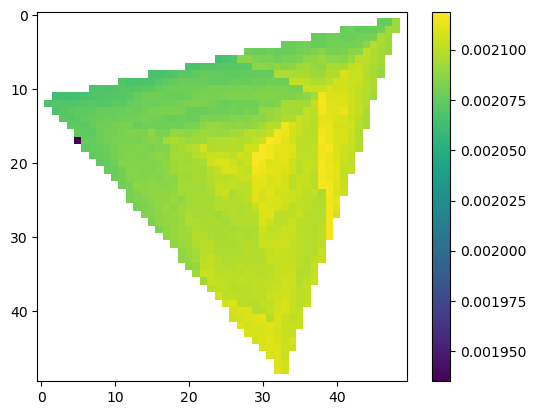

In [139]:
interpolate.griddata(
    np.transpose(np.vstack((
        points_and_fields.query("height == 10").x, 
        points_and_fields.query("height == 10").y
    ))),
    points_and_fields.query("height == 10")['r'],
    (xx, yy), 
    method='linear'
)

plt.imshow(np.nanmedian(np.array(mixingratio_fields), axis=0)[:,:,10])
plt.colorbar()

In [36]:
(
    conservation_spatial_mean_composite_plot(
        conservation_spatial_mean_df,
        [
            'advective_term_lateral', 'advective_term_vertical', 'advective_term_total', 
            'airdensityflux_term_vertical', 'turbulent_term_vertical', 'storage_change', 'source'
        ],
        title='All data', normalize = 7
    ) | conservation_spatial_mean_composite_plot(
        conservation_spatial_mean_df,
        [
            'advective_term_lateral', 'advective_term_vertical', 'advective_term_total', 
            'airdensityflux_term_vertical', 'turbulent_term_vertical', 'storage_change', 'source'
        ],
        title='No BS', normalize = 7,
        times_filter = set(nobs_times)
    ) | conservation_spatial_mean_composite_plot(
        conservation_spatial_mean_df,
        [
            'advective_term_lateral', 'advective_term_vertical', 'advective_term_total', 
            'airdensityflux_term_vertical', 'turbulent_term_vertical', 'storage_change', 'source'
        ],
        title='No BS, not snowing', normalize = 7,
        times_filter = set(nobs_times).intersection(set(is_not_snowing_dates))
    ) | conservation_spatial_mean_composite_plot(
        conservation_spatial_mean_df,
        [
            'advective_term_lateral', 'advective_term_vertical', 'advective_term_total', 
            'airdensityflux_term_vertical', 'turbulent_term_vertical', 'storage_change', 'source'
        ],
        title='Not snowing', normalize = 7,
        times_filter = set(is_not_snowing_dates)
    ) | conservation_spatial_mean_composite_plot(
        conservation_spatial_mean_df,
        [
            'advective_term_lateral', 'advective_term_vertical', 'advective_term_total', 
            'airdensityflux_term_vertical', 'turbulent_term_vertical', 'storage_change', 'source'
        ],
        title='BS', normalize = 7,
        times_filter = set(bs_times)
    )
).resolve_scale(y='shared', x='shared', color='shared').display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [37]:
(
    conservation_spatial_mean_composite_plot(
        conservation_spatial_mean_df,
        [
            'advective_term_lateral', 'advective_term_vertical', 'advective_term_total', 
            'airdensityflux_term_vertical', 'turbulent_term_vertical', 'storage_change', 'source'
        ],
        title='All data', normalize = 7
    ) | conservation_spatial_mean_composite_plot(
        conservation_spatial_mean_df,
        [
            'advective_term_lateral', 'advective_term_vertical', 'advective_term_total', 
            'airdensityflux_term_vertical', 'turbulent_term_vertical', 'storage_change', 'source'
        ],
        title='Stable, No BS', normalize = 7,
        times_filter = set(tgrad_stable_times).intersection(set(nobs_times))
    ) | conservation_spatial_mean_composite_plot(
        conservation_spatial_mean_df,
        [
            'advective_term_lateral', 'advective_term_vertical', 'advective_term_total', 
            'airdensityflux_term_vertical', 'turbulent_term_vertical', 'storage_change', 'source'
        ],
        title='Neutral, No BS', normalize = 7,
        times_filter = set(tgrad_neutral_times).intersection(set(nobs_times))
    ) | conservation_spatial_mean_composite_plot(
        conservation_spatial_mean_df,
        [
            'advective_term_lateral', 'advective_term_vertical', 'advective_term_total', 
            'airdensityflux_term_vertical', 'turbulent_term_vertical', 'storage_change', 'source'
        ],
        title='Unstable, No BS', normalize = 7,
        times_filter = set(tgrad_unstable_times).intersection(set(nobs_times))
    )
).resolve_scale(y='shared', x='shared', color='shared').display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [39]:
(
    conservation_spatial_mean_composite_plot(
        conservation_spatial_mean_df,
        [
            'advective_term_lateral', 'advective_term_vertical', 'advective_term_total', 
            'airdensityflux_term_vertical', 'turbulent_term_vertical', 'storage_change',	'source'
        ],
        title='Flux density terms (g/m^2/s)', normalize = 7,
        times_filter = set(nobs_times)
    ) 
    | 
    alt.Chart(
        tidy_df[
            tidy_df.variable.isin(['w_h2o__3m_c', 'w_h2o__5m_c', 'w_h2o__10m_c'])
            &
            tidy_df.time.isin(set(nobs_times))
        ]
    ).mark_line().encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('median(value):Q'),
        alt.Color('height:O')
    ).properties(
        width = 200, height = 200, title=('Vertical eddy covariance flux (g/m^2/s)')
    )
).resolve_scale(y='shared', color='independent').configure_legend(orient='top', columns=2).display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [40]:

src1 = conservation_spatial_mean_df.set_index('time').loc['20221221': '20221223'].reset_index().assign(casestudy = 1)
src2 = conservation_spatial_mean_df.set_index('time').loc['20221212': '20221214'].reset_index().assign(casestudy = 2)
src3 = conservation_spatial_mean_df.set_index('time').loc['20230201': '20230203'].reset_index().assign(casestudy = 3)
src = pd.concat([src1, src2, src3])
alt.Chart(src).transform_fold([
    'advective_term_lateral', 'advective_term_vertical',
    'advective_term_total', 'airdensityflux_term_vertical',
    'turbulent_term_vertical', 'storage_change', 'source',
]).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q').scale(domain=[-0.04,0.04], clamp=True),
    alt.Color('key:N'),
    alt.Facet('casestudy:N').title(None)
).properties(width = 300, height = 200).resolve_scale(x='independent').display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [44]:
alt.Chart(
    conservation_spatial_mean_df.set_index('time').loc['20230401': '20230407'].reset_index()
).transform_fold([
    'advective_term_lateral', 'advective_term_vertical',
    'advective_term_total', 'airdensityflux_term_vertical',
    'turbulent_term_vertical', 'storage_change', 'source',
]).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q').scale(domain=[-0.04,0.04], clamp=True),
    alt.Color('key:N'),
    alt.Facet('casestudy:N').title(None)
).properties(width =600, height = 200).resolve_scale(x='independent').display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [ ]:
(
    (
        alt.Chart(
            (conservation_spatial_mean_df.set_index('time') * 7).loc['20230201': '20230207'].reset_index().assign(casestudy = 3)
        ).transform_fold([
            # 'advective_term_lateral', 
            # 'advective_term_vertical',
            'advective_term_total', 
            'airdensityflux_term_vertical',
            'turbulent_term_vertical', 
            # 'storage_change', 
            # 'source',
        ]).mark_line().encode(
            alt.X('time:T').axis(None),
            alt.Y('value:Q').scale(domain=[-0.04,0.04], clamp=True).title('Flux density (g/m^2/s)'),
            alt.Color('key:N'),
            alt.Facet('casestudy:N').title(None)
        ).properties(width = 800, height = 200) &\
        alt.Chart(
            tidy_df.query("variable == 'w_h2o__3m_c'").set_index('time').loc['20230201': '20230207'].reset_index()
        ).mark_line().encode(
            alt.X('time:T').axis(None),
            alt.Y('value:Q').title(["Vertical eddy cov.", "flux density (g/m^2/s)"]),
            alt.Color('height:O')
        ).properties(width = 800, height = 100)
     ).resolve_scale(y='shared') &\
    alt.Chart(
        tidy_df.query("measurement == 'wind direction'").query("tower == 'c'").query(
            "height <= 10"
        ).set_index('time').loc['20230201': '20230207'].reset_index()
    ).mark_line().encode(
        alt.X('time:T').axis(None),
        alt.Y('value:Q').title('Wind Dir. (˚)'),
        alt.Color('height:O')
    ).properties(width = 800, height = 100) &\
    alt.Chart(
        tidy_df.query("variable == 'Ri_3m_c'").set_index('time').loc['20230201': '20230207'].reset_index()
    ).mark_line().encode(
        alt.X('time:T').axis(None),
        alt.Y('value:Q').scale(type='symlog', domain=[-10,10], clamp=True).title('Ri (at 3 meters)'),
        alt.Color('height:O')
    ).properties(width = 800, height = 100) &\
    alt.Chart(
        tidy_df.query("variable == 'spd_10m_c'").set_index('time').loc['20230201': '20230207'].reset_index()
    ).mark_line().encode(
        alt.X('time:T'),
        alt.Y('value:Q').title('Wind speed (m/s)'),
        alt.Color('height:O')
    ).properties(width = 800, height = 100)
).resolve_scale(color='independent')

In [ ]:
alt.Chart(
    tidy_df.query("measurement == 'wind direction'").query("tower == 'c'").query(
        "height <= 10"
    ).set_index('time').loc['20221221': '20221223'].reset_index()
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('height:O')
).properties(width = 300, height = 200) | alt.Chart(
    tidy_df.query("measurement == 'wind direction'").query("tower == 'c'").query(
        "height <= 10"
    ).set_index('time').loc['20221212': '20221214'].reset_index()
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('height:O')
).properties(width = 300, height = 200) | alt.Chart(
    tidy_df.query("measurement == 'wind direction'").query("tower == 'c'").query(
        "height <= 10"
    ).set_index('time').loc['20230201': '20230203'].reset_index()
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('height:O')
).properties(width = 300, height = 200)

In [ ]:
src = tidy_df[
    tidy_df.time.isin(
        set(nobs_times).intersection(set(is_not_snowing_dates))
    )
]
src = src[src.variable.isin(['w_h2o__3m_c', 'w_h2o__5m_c', 'w_h2o__10m_c'])]
alt.Chart(
    src
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('height:O')
).properties(height = 200, width = 200, title='Vertical turbulent flux (g/m^2/s)')

In [ ]:
alt.Chart(
    tidy_df.query("measurement == 'air density'").query("height > 0")
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').scale(zero=False),
    alt.Color('height:O')
) | alt.Chart(
    tidy_df.query("measurement == 'temperature'").query("height > 0")
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').scale(zero=False),
    alt.Color('height:O')
)

In [ ]:
src = mixing_ratio_field_df.copy()
src.columns = src.columns.droplevel(2)
src.columns = [f"{int(c1)}_{c2}" for (c1,c2) in zip(
    src.columns.get_level_values(0),
    src.columns.get_level_values(1)
)]
src = src.melt(ignore_index=False)
src['height'] = src['variable'].apply(lambda s: int(s.split('_')[0]))
src['tower'] = src['variable'].apply(lambda s: s.split('_')[1])
src = src[src.tower != 'c']
daily_mixingratio_chart = alt.Chart(src.reset_index()).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').scale(zero=False),
    alt.Color('tower:N'),
    alt.StrokeDash('height:O'),
).properties(title='Daily composite water vapor mixing ratio (g/g)')

In [ ]:
tc_field_df = tidy_df[tidy_df.measurement.isin(['virtual temperature']) & tidy_df.height.isin(HEIGHTS)]
tc_field_df.measurement = 'tc'
tc_field_df = round(
    tc_field_df.pivot_table(
        index='time', columns=['height', 'tower', 'measurement'], values='value'
    ), 
    4
)

src = tc_field_df.copy()
src.columns = src.columns.droplevel(2)
src.columns = [f"{int(c1)}_{c2}" for (c1,c2) in zip(
    src.columns.get_level_values(0),
    src.columns.get_level_values(1)
)]
src = src.melt(ignore_index=False)
src['height'] = src['variable'].apply(lambda s: int(s.split('_')[0]))
src['tower'] = src['variable'].apply(lambda s: s.split('_')[1])
src = src[src.tower != 'c']
daily_sonic_temp_chart = alt.Chart(src.reset_index()).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').scale(zero=False
                                   ),
    alt.Color('tower:N'),
    alt.StrokeDash('height:O'),
).properties(title='Daily composite sonic temperature (˚C)')

In [ ]:
(daily_mixingratio_chart | daily_sonic_temp_chart
).display(renderer='svg')

In [ ]:
alt.Chart(src[src.index >= "20221201 0000"].reset_index()).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').scale(zero=False
                                   ),
    alt.Color('tower:N'),
    alt.StrokeDash('height:O'),
    alt.Facet('month(time):T', columns=3).sort(['Dec', 'Jan', 'Feb', 'Mar', 'Apr'])
).properties(title='Daily composite sonic temperature (˚C)', height=200, width=200).resolve_scale(y='independent').display(renderer='svg')